## Check Remote Server Status

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11528795035022813546
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7441032807
locality {
  bus_id: 1
  links {
  }
}
incarnation: 90069864950761477
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
]


## Import Notebook Dependendencies

In [76]:
import gc
from numba import cuda
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import fbeta_score

import matplotlib.pyplot as plt
%matplotlib inline

## Read in the data

### Training Data

In [90]:
training = pd.read_csv("./kaggle_csv_files/files_and_labels_dataframe.csv")
training['file_path'] = "./train_data/" + training['image_name'] + ".tif"
training.head()

,image_name,labels,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down,file_path
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,./train_data/train_0.tif
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,./train_data/train_1.tif
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,./train_data/train_2.tif
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,./train_data/train_3.tif
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,./train_data/train_4.tif


In [4]:
label_columns = ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation',
       'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy',
       'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
       'selective_logging', 'blow_down']

### Test data

In [5]:
# As a reminder, our submission data will have this format.
test_data = pd.read_csv("./kaggle_csv_files/sample_submission_v2.csv")
test_data.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [6]:
# We can drop the "tags" column for now.
test_data.drop(columns = ['tags'], inplace = True)
test_data['file_path'] = test_data['image_name'].map(\
                    lambda x: ("./fixed/" + x + ".tif") if "file_" in x \
                    else ("./test_data/" + x + ".tif"))

In [7]:
# Looks good!
test_data.head()

,image_name,file_path
0,test_0,./test_data/test_0.tif
1,test_1,./test_data/test_1.tif
2,test_2,./test_data/test_2.tif
3,test_3,./test_data/test_3.tif
4,test_4,./test_data/test_4.tif


In [8]:
test_data.tail()

,image_name,file_path
61186,file_9995,./fixed/file_9995.tif
61187,file_9996,./fixed/file_9996.tif
61188,file_9997,./fixed/file_9997.tif
61189,file_9998,./fixed/file_9998.tif
61190,file_9999,./fixed/file_9999.tif


### Predictions to Label Tags

In [38]:
# This function converts our model predictions directly to the format suitable for submission.
def predictions_to_tags(predictions, label_columns, threshold_list):
    
    # convert predictions to binary
    threshold_map = {column: value for column, value in enumerate(threshold_list)}
    
    binary_preds_list = []
    for pred in predictions:
        binary_pred = [1 if value > threshold_map[i] else 0 for i,value in enumerate(pred)]
        binary_preds_list.append(binary_pred)

    labels_map = {index: column for index, column in enumerate(label_columns)}
    
    # convert binary to tag
    prediction_labels_list = []
    for image_pred in binary_preds_list:
        tags = [labels_map[index] for index, value in enumerate(image_pred) if value == 1]
        prediction_labels_list.append(tags)

    return [' '.join(prediction) for prediction in prediction_labels_list] 

In [9]:
# # This function converts our model predictions directly to the format suitable for submission.

# # could potentially do threshold list but for now...

# def predictions_to_tags(predictions, label_columns, threshold):
#     binary_predictions = (predictions > threshold).astype(int) 
    
# #     predictions_label = []
# #     for prediction in pred_Y:
# #     labels = [y_map[i] for i,value in enumerate(prediction) if value > thresholds[i]]
# #     predictions_label.append(labels)
    
#     prediction_labels_list = []
#     labels_map = {index: column for index, column in enumerate(label_columns)}
    
#     for image_pred in binary_predictions:
#         tags = [labels_map[index] for index, value in enumerate(image_pred) if value == 1]
#         prediction_labels_list.append(tags)
#     return [' '.join(prediction) for prediction in prediction_labels_list]

### F2 Score

**This is the evaluation metric used in the competition**

In [10]:
# need to separately define own manual fbeta score such that arrays can be passed as tensor in modeling.
# Then, we can use this as a metric in the fit_generator.
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

    return result

### Image Data Generator and Image Augmentation

Code derived from this [medium post.](https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24)

In [11]:
# train generator
def train_generator(batch_size,
                    dataframe,
                    target_size,
                    x_col = 'file_path', 
                    labels = label_columns):

    
    datagen = ImageDataGenerator(rescale = 1./255.,
                                 horizontal_flip = True,
                                 vertical_flip = True, 
                                 rotation_range = 45,
                                 fill_mode = "nearest",
                                 dtype = "float16")
    
    train_generator = datagen.flow_from_dataframe(
                                dataframe = dataframe,
                                directory = None,
                                x_col = x_col,
                                y_col = labels,
                                batch_size = batch_size,
                                shuffle = True,
                                class_mode = "other",
                                target_size = target_size,
                                seed = 42)
    return train_generator

# validation generator
def valid_generator(batch_size,
                    dataframe,
                    target_size,
                    x_col = 'file_path', 
                    labels = label_columns):
    
    valid_datagen = ImageDataGenerator(rescale = 1./255.,
                                 horizontal_flip = True,
                                 vertical_flip = True, 
                                 rotation_range = 45,
                                 fill_mode = "nearest",
                                 dtype = "float16")
    
    valid_generator = valid_datagen.flow_from_dataframe(
                                    dataframe = dataframe,
                                    directory = None,
                                    x_col = x_col,
                                    y_col = labels,
                                    batch_size = batch_size,
                                    shuffle = False,
                                    class_mode = "other",
                                    target_size = target_size,
                                    seed = 42)
    return valid_generator
    
# test generator
def test_generator(batch_size, test_data, target_size, x_col = 'file_path'):
    test_datagen = ImageDataGenerator(rescale = 1./255.,
                                      dtype = 'float16')

    test_generator = test_datagen.flow_from_dataframe(
                                    dataframe = test_data,
                                    directory = None,
                                    x_col = x_col,
                                    batch_size = batch_size,
                                    shuffle = False,
                                    class_mode = None,
                                    target_size = target_size,
                                    seed = 42)
    return test_generator

### Models

In [73]:
# simple Convolutional Neural Network
def simple_cnn(input_shape = (256, 256, 3), 
               weight_path = None):
    
    model = Sequential()

    model.add(BatchNormalization(input_shape = input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape = input_shape))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    if(weight_path!=None):
        if os.path.isfile(weight_path):
            model.load_weights(weight_path)
    
    return model

In [13]:
# Big convolutional Neural Network
def bigger_cnn(input_shape = (256, 256, 3), weights = None):
    model = Sequential()
    model.add(BatchNormalization(input_shape = input_shape))

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    if(weight_path!=None):
        if os.path.isfile(weight_path):
            model.load_weights(weight_path)
    
    return model

In [14]:
# Residual Network - 50
def resnet50(input_shape = (256, 256, 3), weights = None):
    from keras.model.resnet50 import ResNet50
    base_resnet = ResNet50(include_top = False, 
                           weights = 'imagenet',  
                           pooling = None, 
                           classes = 17)

    model = Sequential()
    model.add(BatchNormalization(input_shape = input_shape))
    model.add(base_resnet)
    model.add(Flatten())
    model.add(Dense(17, activation='sigmoid'))
   
    if(weight_path!=None):
        if os.path.isfile(weight_path):
            model.load_weights(weight_path)
    return model

## 3 - Fold Cross Validation: 

**I could not get this function to run on multiple KFolds due to Resource Exhaust Error on my remote server.**

In [15]:
def KFold_Train(data, model, num_epochs, labels = label_columns, 
                file_path = 'file_path', n_splits = 3, batch_size = 256):
    
    X = data[file_path]
    y = data[labels]
    
    history_list = []
    
    kf = KFold(n_splits = n_splits, shuffle = False, random_state = 42)
    folds = kf.split(X = X, y = y)

    num_fold = 0
    for train_index, val_index in folds:
        
        model = model
        input_shape = model.input_shape[1:3]

        X_train = X.iloc[train_index]
        Y_train = y.iloc[train_index]
        X_val = X.iloc[val_index]
        Y_val  = y.iloc[val_index]

        num_fold += 1
        print('Starting KFold number {} of {}'.format(num_fold, n_splits))

        print('Split train: ', len(X_train), len(Y_train))    
        train_gen = train_generator(dataframe = data.iloc[train_index], target_size = input_shape,
                                    batch_size = batch_size, x_col= file_path, labels = labels)

        print('Split valid: ', len(X_val), len(Y_val))
        val_gen = valid_generator(dataframe = data.iloc[val_index], target_size = input_shape,
                                   batch_size = 2 * batch_size, x_col= file_path, labels = labels)
    
        model.compile( optimizer = "adam",
              loss='binary_crossentropy',
              metrics=["accuracy", fbeta_score_K])
  
        callbacks = [
                EarlyStopping(monitor='val_loss', patience=2, verbose=0),
                ModelCheckpoint("./saved_val_models/{}_fold_{}.hdf5".format(str(model), str(num_fold)), 
                                monitor='val_loss', save_best_only=True, verbose=0)]
        
        history = model.fit_generator(train_gen, 
                            steps_per_epoch = (train_gen.n//train_gen.batch_size + 1),
                            validation_data = val_gen,
                            validation_steps = (val_gen.n//val_gen.batch_size + 1),
                            epochs = num_epochs,
                            callbacks = callbacks,
                            use_multiprocessing = True,
                            verbose = 1)
        
        history_list.append(history)
        
        
        validation_pred = model.predict_generator(val_gen, 
                                                  steps = (val_gen.n//val_gen.batch_size + 1),
                                                  verbose = 1)

        np.save("./kfold_val_preds/{}_val_preds_fold_{}".format(str(model), str(num_fold)),
                arr = validation_pred)
        
        print("Validation F-Score: ", fbeta_score(Y_val, y_pred = (np.array(validation_pred) > 0.2), 
                          beta=2, average='samples'))
        
                
    return history_list

### Simple CNN Cross Validation

In [127]:
# simple_cnn_kfold = KFold_Train(data = training,
#                                model = simple_cnn(input_shape = (64, 64, 3)), 
#                                num_epochs = 1, 
#                                n_splits = 3,
#                                batch_size = 16)

# Train - Val Split Model Run

In [16]:
def run_model(data, model, num_epochs, labels = label_columns, 
              file_path = 'file_path', batch_size = 128, test_data = test_data):
  
    X_train, X_val = train_test_split(data, random_state = 42)
    Y_val = X_val[labels]

    model = model
    input_shape = model.input_shape[1:3]

    print('Split train: ', len(X_train))    
    train_gen = train_generator(dataframe = X_train, target_size = input_shape,
                                batch_size = batch_size, x_col= file_path, labels = labels)

    print('Split valid: ', len(X_val))
    val_gen = valid_generator(dataframe = X_val, target_size = input_shape,
                               batch_size = batch_size * 2, x_col= file_path, labels = labels)

    model.compile(optimizer = "adam",
                  loss='binary_crossentropy',
                  metrics=["accuracy", fbeta_score_K])

    callbacks = [
                EarlyStopping(monitor='val_loss', patience=2, verbose=0),
                ModelCheckpoint("./saved_val_models/{}.hdf5".format(str(model)), 
                                monitor='val_loss', save_best_only=False, verbose=0)]
    
    history = model.fit_generator(train_gen, 
                        steps_per_epoch = (train_gen.n//train_gen.batch_size + 1),
                        validation_data = val_gen,
                        validation_steps = (val_gen.n//val_gen.batch_size + 1),
                        callbacks = callbacks,
                        epochs = num_epochs,
                        use_multiprocessing = True,
                        verbose = 1)        

    validation_pred = model.predict_generator(val_gen, 
                                              steps = (val_gen.n//val_gen.batch_size + 1),
                                              verbose = 1)
    
    np.save("./run_val_preds/{}.validation_pred".format(str(model)), arr = validation_pred)
    np.save("./run_val_true/{}.y_val".format(str(model)), arr = Y_val)
    
    print("Validation F-Score: ", fbeta_score(Y_val, y_pred = (np.array(validation_pred) > 0.2), 
                          beta=2, average='samples'))
    
    print("Loading the test data...")
    test_gen = test_generator(batch_size = batch_size * 2, 
                              test_data = test_data,
                              target_size = input_shape)
    
    test_predictions = model.predict_generator(test_gen, 
                                               steps = (test_gen.n // test_gen.batch_size + 1),
                                               verbose = 1)
    
    print("Saving test predictions...")
    np.save("./test_raw_preds/{}_pre_threshold.npy".format(str(model)), arr = test_predictions)
    print("Saved!")
    
    return model, history

## Running Simple CNN without Cross Validation

In [17]:
simple_cnn, model_history = run_model(data = training, 
                                      model = simple_cnn(input_shape=(128, 128, 3)), 
                                      num_epochs = 20, 
                                      labels = label_columns, 
                                      file_path = 'file_path', 
                                      batch_size = 32,
                                      test_data = test_data)

Split train:  30359
Found 30359 images.
Split valid:  10120
Found 10120 images.
Epoch 1/20
949/949 [==============================] - 418s 440ms/step - loss: 0.2540 - acc: 0.9048 - fbeta_score_K: 0.6020 - val_loss: 0.1953 - val_acc: 0.9208 - val_fbeta_score_K: 0.6437
Epoch 2/20
949/949 [==============================] - 247s 260ms/step - loss: 0.2124 - acc: 0.9145 - fbeta_score_K: 0.6311 - val_loss: 0.1944 - val_acc: 0.9195 - val_fbeta_score_K: 0.6344
Epoch 3/20
949/949 [==============================] - 246s 259ms/step - loss: 0.2045 - acc: 0.9166 - fbeta_score_K: 0.6410 - val_loss: 0.1893 - val_acc: 0.9234 - val_fbeta_score_K: 0.6700
Epoch 4/20
949/949 [==============================] - 247s 260ms/step - loss: 0.2011 - acc: 0.9184 - fbeta_score_K: 0.6465 - val_loss: 0.1874 - val_acc: 0.9253 - val_fbeta_score_K: 0.6740
Epoch 5/20
949/949 [==============================] - 247s 260ms/step - loss: 0.1964 - acc: 0.9208 - fbeta_score_K: 0.6547 - val_loss: 0.1792 - val_acc: 0.9266 - val_fb

## Visualing Training Performance

In [ ]:
def history_plotting(model_history_dict):
    model_history_dict.

In [20]:
len(model_history.history)

6

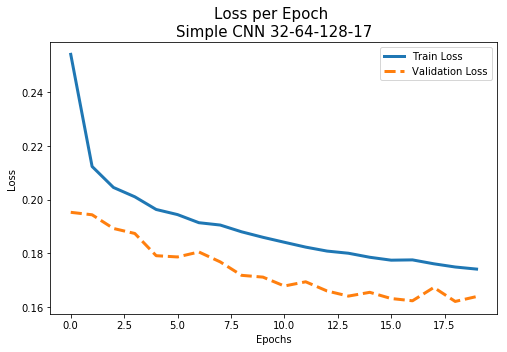

In [22]:
plt.figure(figsize = (8, 5))
plt.title("Loss per Epoch \nSimple CNN 32-64-128-17", fontsize = 15)

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(model_history.history['loss'], 
         label = "Train Loss",
         linewidth = 3)
plt.plot(model_history.history['val_loss'], 
         label = "Validation Loss", 
         linestyle = "--", 
         linewidth = 3)

plt.legend();

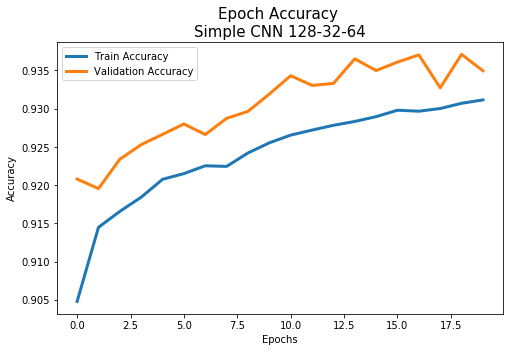

In [23]:
plt.figure(figsize = (8, 5))
plt.title("Epoch Accuracy \nSimple CNN 128-32-64", fontsize = 15)

plt.plot(model_history.history['acc'], 
         label = "Train Accuracy",
         linewidth = 3)
plt.plot(model_history.history["val_acc"], 
         label = "Validation Accuracy", 
         linewidth = 3)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend();

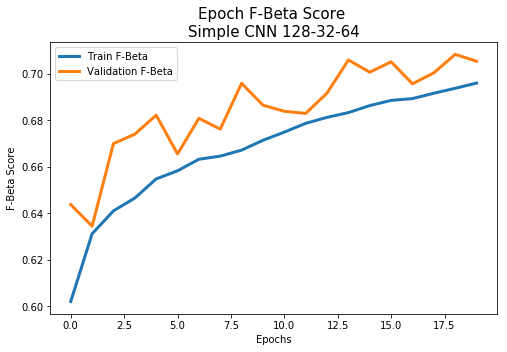

In [27]:
plt.figure(figsize = (8, 5))
plt.title("Epoch F-Beta Score \nSimple CNN 128-32-64", fontsize = 15)

plt.plot(model_history.history['fbeta_score_K'], 
         label = "Train F-Beta",
         linewidth = 3)
plt.plot(model_history.history["val_fbeta_score_K"], 
         label = "Validation F-Beta", 
         linewidth = 3)

plt.xlabel("Epochs")
plt.ylabel("F-Beta Score")

plt.legend();

## Gridsearching Thresholds

In [34]:
# load validation predictions
val_pred = \
        np.load("./run_val_preds/<keras.engine.sequential.Sequential object at 0x7f6c95cb4080>.validation_pred.npy")
print("{} validation predictions.".format(val_pred.shape[0]))

#load true validation labels
y_val = np.load("./run_val_true/<keras.engine.sequential.Sequential object at 0x7f6c95cb4080>.y_val.npy")
print("{} true validation labels .".format(val_pred.shape[0]))



10120 validation predictions.
10120 true validation labels .


**Intital thresholds set at 0.2. These gave a test F-Beta of 0.83338.**

In [57]:
# gridsearch thresholds
def optimise_f2_thresholds(y, p, verbose=True, resolution=100):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(17):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
            score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.2]*17
    for i in range(17):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            i2 /= resolution
            x[i] = i2
            score = mf(x)
            if score > best_score:
                best_i2 = i2
                best_score = score
        x[i] = best_i2
        if verbose:
              print(i, best_i2, best_score)

        return x

In [58]:
best_thresholds = optimise_f2_thresholds(y_val, val_pred)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0 0.16 0.8431662324462348


**These thresholds improved my test F-Beta to 0.83406.**

In [63]:
best_thresholds = [0.16] * 17
print(best_thresholds)

[0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16]


These thresholds were found independently by a Kaggler. 
I figured I would see how they improved my F-beta score.
These actually gave me the highest score: 0.83584


In [61]:
threshy = [0.1925, 0.2625, 0.245, 0.2375, 0.205, 0.2175, 0.21, 0.265, 0.085, 
           0.12, 0.1625, 0.0875, 0.2225, 0.1375, 0.19, 0.14, 0.0475]

# Predict on test

In [32]:
# load in the test data
test_preds = \
    np.load("./test_raw_preds/<keras.engine.sequential.Sequential object at 0x7f6c95cb4080>_pre_threshold.npy")

test_preds.shape


(61191, 17)

In [55]:
# function to convert raw prediction to tags and create submission file
def submit_predictions(preds, labels, thresholds, file_path):
    tags = predictions_to_tags(preds, labels, threshold_list=thresholds)
    submission = test_data[['image_name']]
    submission['tags'] = tags
    submission.to_csv(file_path, index = False)

In [56]:
# submit predictions!
submit_predictions(test_preds, label_columns, 
                   thresholds = [0.2 for i in range(17)],
                   file_path = "./kaggle_submit_preds/pre_thresh_search.csv")

In [62]:
submit_predictions(test_preds, label_columns, 
                   thresholds = threshy,
                   file_path = "./kaggle_submit_preds/cheat_thresh_search.csv")

In [83]:
submit_predictions(test_preds, label_columns, 
                   thresholds = best_thresholds,
                   file_path = "./kaggle_submit_preds/best_thresholds.csv")

### Loading in the Model

In [77]:
final_model, final_run_history = run_model(
        
        data = training, 
        model = simple_cnn(input_shape=(128, 128, 3),
            weight_path = "./saved_val_models/<keras.engine.sequential.Sequential object at 0x7f6c95cb4080>.hdf5"), 
        num_epochs = 20, 
        labels = label_columns, 
        file_path = 'file_path', 
        batch_size = 32,
        test_data = test_data
)

Split train:  30359
Found 30359 images.
Split valid:  10120
Found 10120 images.
Epoch 1/20
949/949 [==============================] - 307s 324ms/step - loss: 0.1755 - acc: 0.9308 - fbeta_score_K: 0.6948 - val_loss: 0.1601 - val_acc: 0.9380 - val_fbeta_score_K: 0.7098
Epoch 2/20
949/949 [==============================] - 245s 259ms/step - loss: 0.1751 - acc: 0.9306 - fbeta_score_K: 0.6943 - val_loss: 0.1607 - val_acc: 0.9370 - val_fbeta_score_K: 0.6993
Epoch 3/20
949/949 [==============================] - 242s 255ms/step - loss: 0.1738 - acc: 0.9314 - fbeta_score_K: 0.6963 - val_loss: 0.1586 - val_acc: 0.9385 - val_fbeta_score_K: 0.7168
Epoch 4/20
949/949 [==============================] - 245s 258ms/step - loss: 0.1737 - acc: 0.9315 - fbeta_score_K: 0.6971 - val_loss: 0.1627 - val_acc: 0.9367 - val_fbeta_score_K: 0.7014
Epoch 5/20
159/159 [==============================] - 51s 319ms/step
Validation F-Score:  0.8463586141067426
Loading the test data...
Found 61191 images.
957/957 [=====

## Visualizing Re-Initiated Model

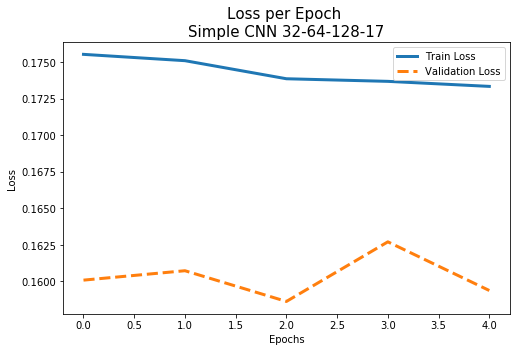

In [78]:
plt.figure(figsize = (8, 5))
plt.title("Loss per Epoch \nSimple CNN 32-64-128-17", fontsize = 15)

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(final_run_history.history['loss'], 
         label = "Train Loss",
         linewidth = 3)
plt.plot(final_run_history.history['val_loss'], 
         label = "Validation Loss", 
         linestyle = "--", 
         linewidth = 3)

plt.legend();

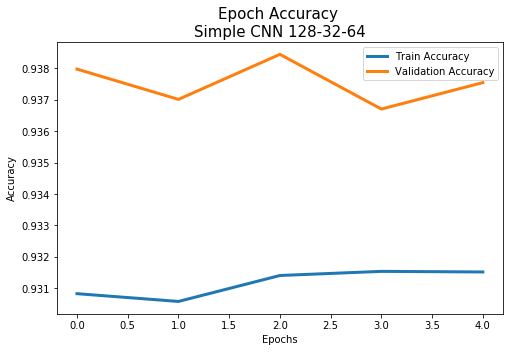

In [79]:
plt.figure(figsize = (8, 5))
plt.title("Epoch Accuracy \nSimple CNN 128-32-64", fontsize = 15)

plt.plot(final_run_history.history['acc'], 
         label = "Train Accuracy",
         linewidth = 3)
plt.plot(final_run_history.history["val_acc"], 
         label = "Validation Accuracy", 
         linewidth = 3)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend();

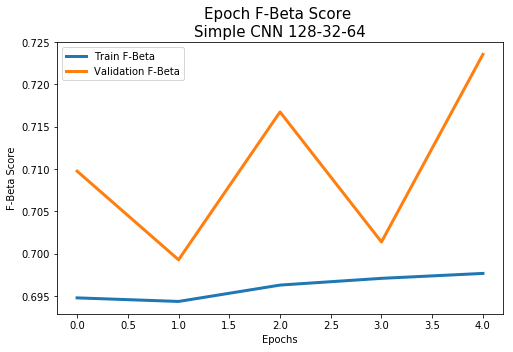

In [80]:
plt.figure(figsize = (8, 5))
plt.title("Epoch F-Beta Score \nSimple CNN 128-32-64", fontsize = 15)

plt.plot(final_run_history.history['fbeta_score_K'], 
         label = "Train F-Beta",
         linewidth = 3)
plt.plot(final_run_history.history["val_fbeta_score_K"], 
         label = "Validation F-Beta", 
         linewidth = 3)

plt.xlabel("Epochs")
plt.ylabel("F-Beta Score")

plt.legend();

## Final Predictions

**F-Beta Score: 0.83406**

In [81]:
final_pred = np.load("./test_raw_preds/<keras.engine.sequential.Sequential object at 0x7f6c6876d400>_pre_threshold.npy")

In [84]:
submit_predictions(test_preds, label_columns, 
                   thresholds = best_thresholds,
                   file_path = "./kaggle_submit_preds/final.csv")